In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import time 
import gpytorch
from gpytorch.functions import pivoted_cholesky

from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel
from gpytorch.priors import GammaPrior
from gpytorch.likelihoods import GaussianLikelihood
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
# Set device and global dtype
device = "cuda:0"
global_dtype = torch.float32

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Add project source path
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '../code'))
if src_path not in sys.path:
    sys.path.append(src_path)
from LBFGS import LBFGS

# Import custom modules
from gps import CholeskyGaussianProcess, IterativeGaussianProcess
from util import train, eval, plot_gpr_results, fetch_uci_dataset, memory_dump
from plotting import plot_gp_simple, plot_gp_sample, plot_gp_simple_regions
device = "cuda:0"
# Enable autoreloading of modules
%load_ext autoreload
%autoreload 2
train_x, train_y, test_x, test_y = fetch_uci_dataset('bike',r"C:\Users\fredw\chris\Research\softki\data\uci_datasets\uci_datasets\elevators\data.csv",train_frac=9/10,val_frac=0)
train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print(train_x.shape)

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode
SIZE (16599, 19)
Dataset loaded
torch.Size([14939, 17])


In [2]:
from gpy_hack import *

DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 1/50 - Loss: 1.236441969871521
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 2/50 - Loss: 1.2128541469573975
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 3/50 - Loss: 1.2213510274887085
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 4/50 - Loss: 1.1781129837036133
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 5/50 - Loss: 1.087469458580017
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 6/50 - Loss: 1.091961145401001
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 7/50 - Loss: 1.0588536262512207
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 8/50 - Loss: 1.044326663017273
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 9/50 - Loss: 1.0470761060714722
DEBUG: USING CUSTOM INJECTION in custom_preconditioner1 
Iteration 10/50 - Loss: 1.0104674100875854
DEBUG: USING 

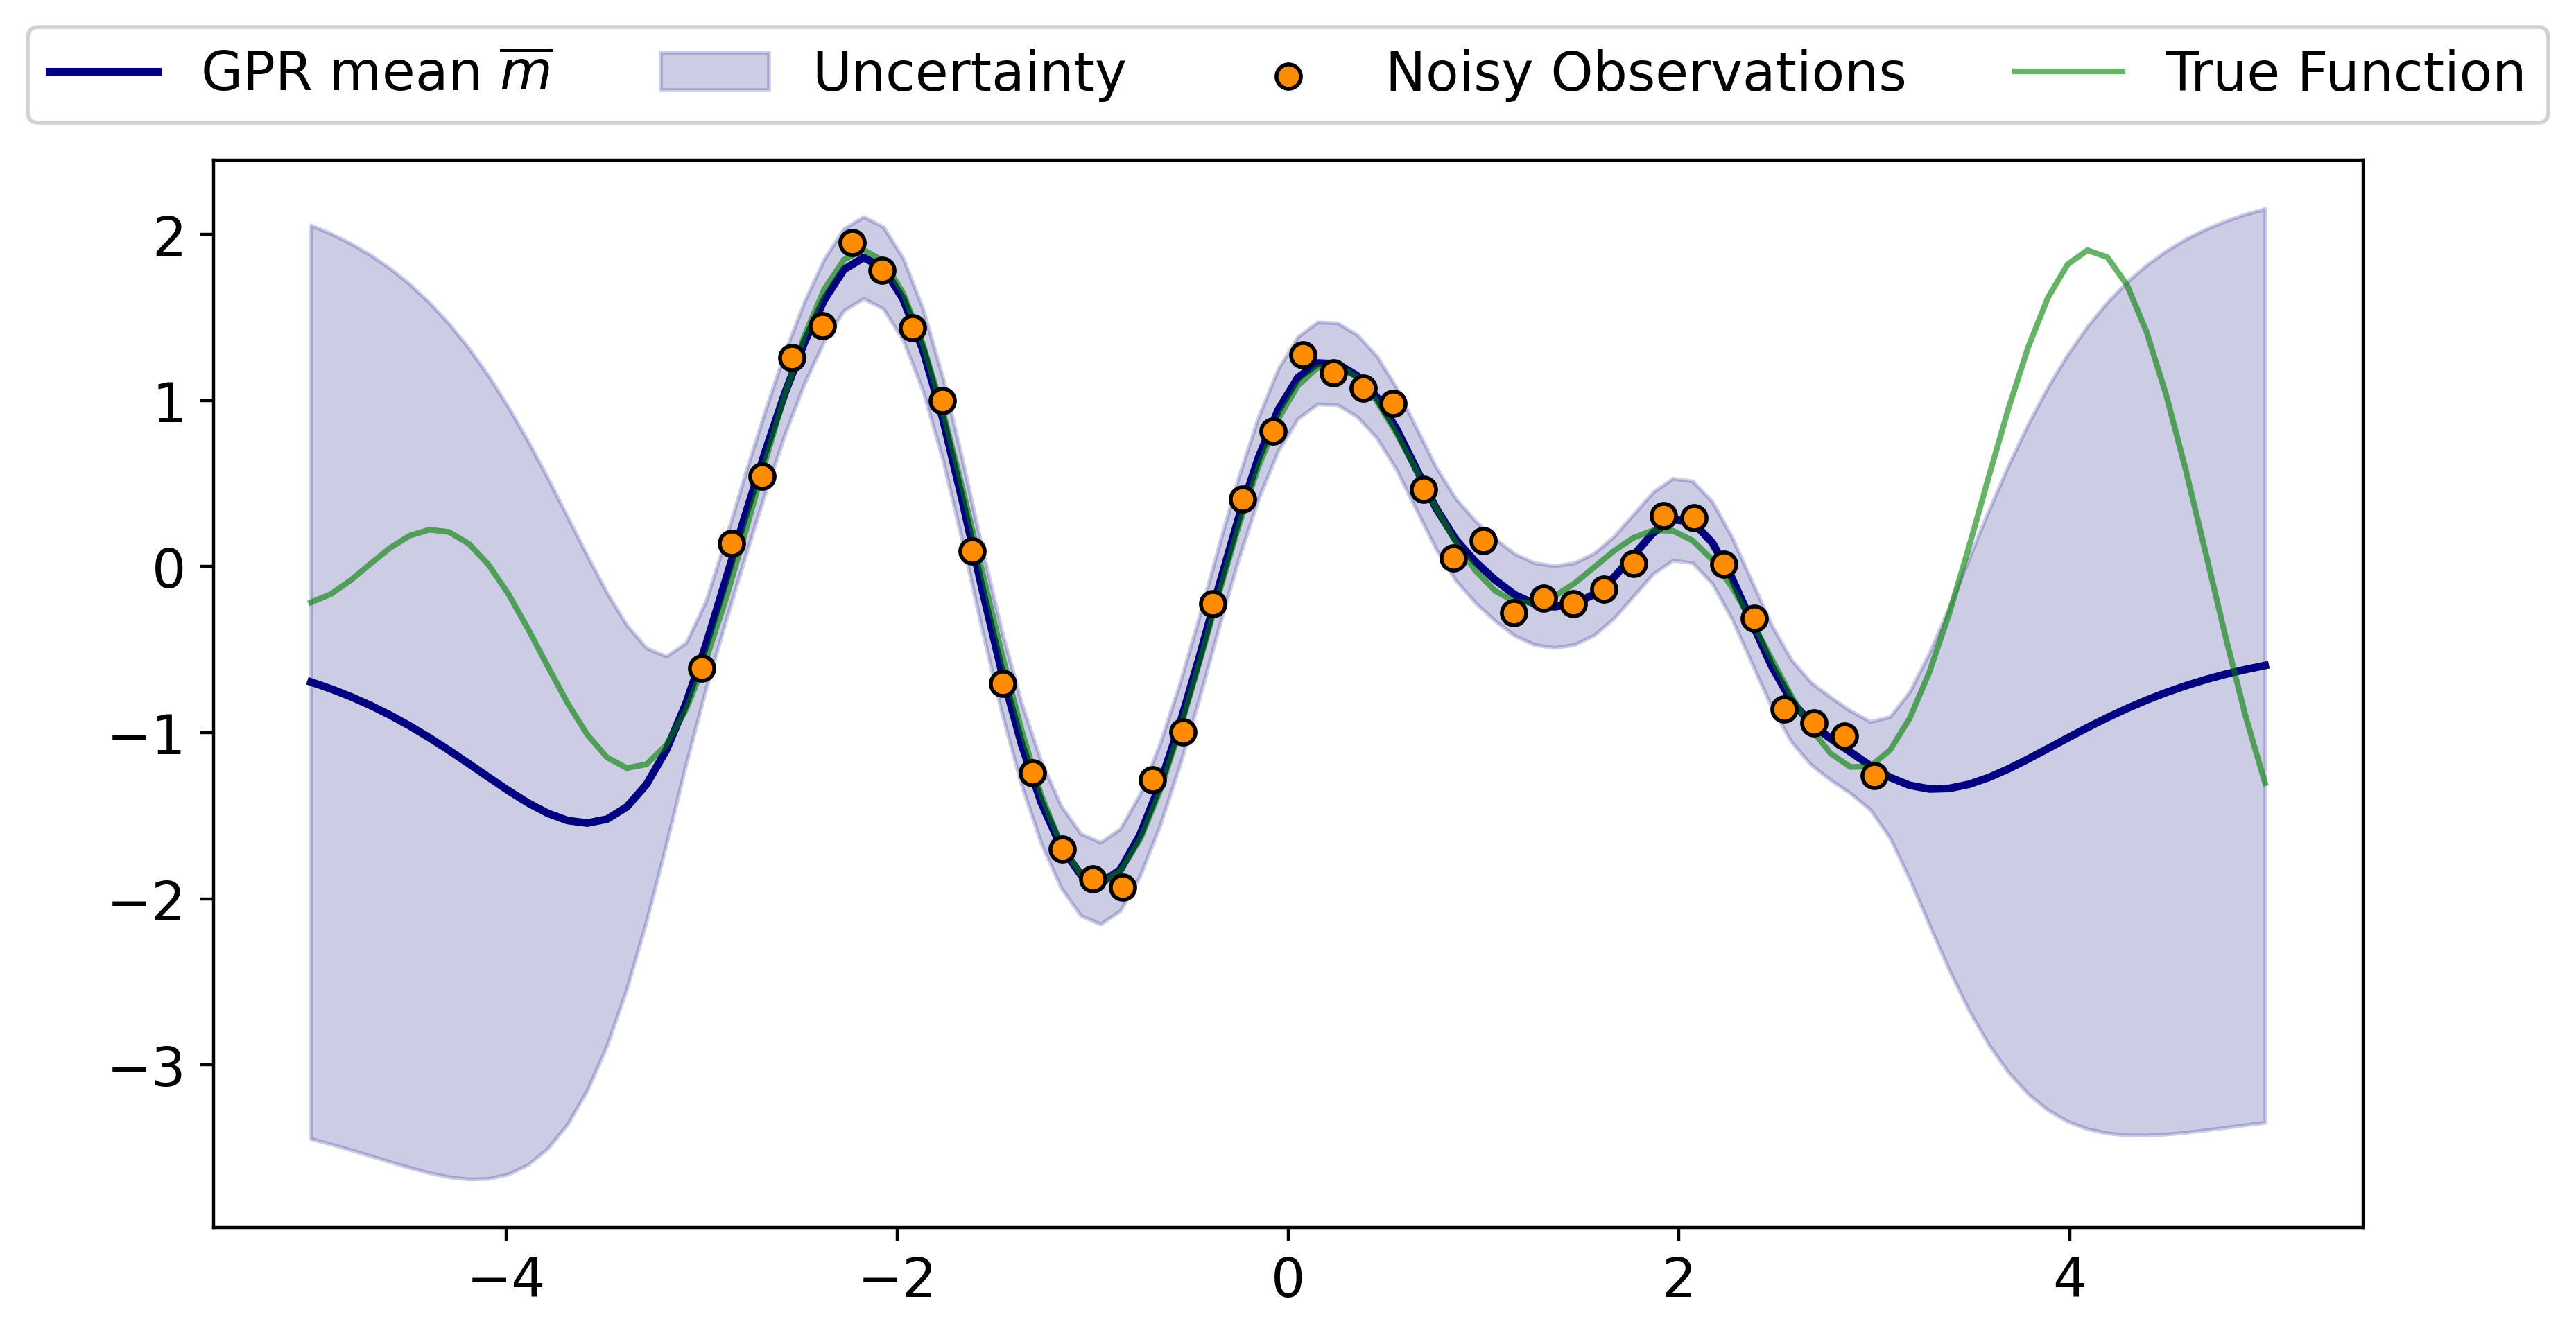

In [3]:
#!/usr/bin/env python3


def true_function(x: Tensor) -> Tensor:
    return torch.sin(2 * x) + torch.cos(3 * x)

def generate_data(true_function, train_range=(-3, 3), test_range=(-3, 3), n_train=40, n_test=100, noise_std=0.1, device="cuda:0", dtype=torch.float32):
    X_train = torch.linspace(train_range[0], train_range[1], n_train, dtype=dtype, device=device).unsqueeze(-1)
    y_train = true_function(X_train) + noise_std * torch.randn_like(X_train)
    X_test = torch.linspace(test_range[0], test_range[1], n_test, dtype=dtype, device=device).unsqueeze(-1)
    y_test = true_function(X_test)
    return X_train, y_train.squeeze(), X_test, y_test.squeeze()

global_dtype = torch.float32
device = torch.device("cuda:0")
train_x, train_y, test_x, test_y = generate_data(true_function, test_range=(-5, 5), dtype=global_dtype, device=device)

likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
base_kernel = MaternKernel(
    ard_num_dims=train_x.shape[-1],
    lengthscale_prior=GammaPrior(3.0, 6.0),
    nu=2.5
)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)
model = ExactGPModel(train_x, train_y, likelihood, kernel).to(device)

model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = CustomExactMarginalLogLikelihood(likelihood, model, custom_preconditioner=custom_preconditioner)

with gpytorch.settings.max_cholesky_size(1):
    training_iterations = 50
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        print(f"Iteration {i + 1}/{training_iterations} - Loss: {loss.item()}")

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    pred_mean = observed_pred.mean
    pred_variance = observed_pred.variance
    pred_std = torch.sqrt(pred_variance)

plot_gp_simple(train_x, train_y, test_x, pred_mean, pred_std, test_y)